##### This software is based on the software provided by Jason Tsang in https://github.com/jasontslxd/PQWGAN within the paper by S. L. Tsang, M. T. West, S. M. Erfani and M. Usman, "Hybrid Quantum–Classical Generative Adversarial Network for High-Resolution Image Generation," in IEEE Transactions on Quantum Engineering, vol. 4, pp. 1-19, 2023  (Hybrid Quantum–Classical Generative Adversarial Network for High-Resolution Image Generation | IEEE Journals & Magazine | IEEE Xplore)   https://arxiv.org/abs/2212.11614
 

#   QBiGAN  (Quantum Bidirectional Generative Adversarial Network)

##### The original software has been modified with the objective to implement a new architecture called Quantum Bidirectional Generative Adversarial Network (QBiGAN). 

###### To be run in a Colab or AWS environment
!pip install pennylane --upgrade
!pip install pennylane-lightning
!pip install pennylane-lightning[gpu]

###### To be run in a Qiskit
!pennylane-sf pennylane-qiskit

###### To be run in a Colab or AWS environment
!pip install autograd

###### To be run in a Colab 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/My Drive/Colab_Notebooks/Patch_Bigan_new_WGAN00020101/

In [1]:
import os
import argparse
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.utils import save_image
#from utils.dataset import load_mnist, load_fmnist, denorm, select_from_dataset
from utils.dataset import load_mnist, load_mnist_test, load_fmnist, load_mnist_test, denorm, select_from_dataset
from utils.wgan import compute_gradient_penalty
from models.QGCCCE import PQWGAN_CC_CE
from datetime import datetime
import random
import matplotlib.pyplot as plt

from IPython.display import Image, display
from PIL import Image as PILImage

from sklearn.manifold import TSNE
import umap

current_time = datetime.now().time()
print("Current time:", current_time)

Current time: 11:40:13.143304


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Parameters initialization
evaluation = True          # True for evaluation mode False for Training mode
classes_str = "0 1"        # classes of MNIST or FMNIST that are used
dataset_str = "mnist"      # default dataset
patches = 16               # number of patches for a single image
patch_shape = (1,16)       # shape of a single patch
layers = 5                 # layers of the quantum generator
n_data_qubits = 5          # number of data qubits             
ancillas = 1               # number of ancilla qubits
qubits = n_data_qubits + ancillas 
batch_size = 25            # number of images per patch     
checkpoint = 4740          # batch number to be used for restart of the system
randn = False              # default is rand
n_epochs = 25              # number of epochs for the training
image_size = 16            # size of the image is image_size * image_size
channels = 1               # number of channels
lr_D = 0.01                # learning rate of the critic (discriminator)
lr_G = 0.008               # learning rate of the generator
lr_E = 0.01                #  learning rate of encoder
b1 = 0.0                   # beta1 of the Adams optimizer
b2 = 0.9                   # beta2 of the ADams optimizer
latent_dim = qubits        # size of the latent vectors
lambda_gp = 5              # lambda parameter of the gradient penalty
n_critic = 1               # number of iteration of the critic for each itaration of the pair generator-encoder
n_EG = 1                   # number of iteration of the generator-encoder
sample_interval = 1        # number of batches to be examined before printing status of the system and recovery files
out_folder = "./output"    # subdirectory containing additional scripts and result/recovery files
out_dir = f"{out_folder}"  # variable for out_folder


In [4]:
#training of the QBiGAN
def train(classes_str, dataset_str, patches, layers, n_data_qubits, batch_size, out_folder, checkpoint, randn, patch_shape):
    
    # format classes to be taken from MNIST or FMNIST
    classes = list(set([int(digit) for digit in classes_str.split()]))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    current_time = datetime.now().time()
    print("Current time:", current_time)
    
    # extract images from dataset defining size of the images (for instance 16*16 instead of 28*28), 
    # classe of the images (for instance 0 and 1), number of images for each class
    # These function are described in the script dataset.py contained in subdirectory ./utils
    if dataset_str == "mnist":
        dataset = select_from_dataset(load_mnist(image_size=image_size), 1000, classes)
        dataset_test = select_from_dataset(load_mnist_test(image_size=image_size), 1000, classes)
    elif dataset_str == "fmnist":
        dataset = select_from_dataset(load_fmnist(image_size=image_size), 1000, classes)
        dataset_test = select_from_dataset(load_fmnist(image_size=image_size), 1000, classes)

################################################################
# 
#   Initial display of a sample of images
#   Number of samples to display
    num_samples = 10
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(15, 2))
    # Iterate and display random samples
    for i in range(num_samples):
        # Select a random sample from the dataset
        index = random.randint(0, len(dataset) - 1)
        image, label = dataset[index]
        # Convert the tensor image to a numpy array for visualization
        # Also, denormalize the image
        image = image.numpy().squeeze() * 0.5 + 0.5
        # Display the image in a subplot
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')  # Hide the axes ticks
    # Adjust the layout and display the figure
    plt.tight_layout()
    plt.show()
    
####################################################################

# check whether output folder exists already
    os.makedirs(out_dir,exist_ok=True)

#   Define Model for the system 
#   The Model includes Critic, Quantum Generator and Encoder
#   The model is described in the script QGCCCE contained in subdirectory ./models 
    gan = PQWGAN_CC_CE(image_size=image_size, channels=channels, n_generators=patches, n_qubits=qubits, n_ancillas=ancillas, n_layers=layers, patch_shape=patch_shape, latent_dim=latent_dim)

    encoder = gan.encoder
    critic = gan.critic
    generator = gan.generator

#   feed the dataloader for image processing
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=1)

#   Define the optimizers for the critic and for the pair generator-encoder   
    optimizer_EG = torch.optim.Adam([{'params': encoder.parameters(), 'lr': lr_E},{'params': generator.parameters(), 'lr': lr_G}], betas=(0.5, 0.999))
    optimizer_C = Adam(critic.parameters(), lr=lr_D, betas=(b1, b2))

#   prepare a batch of batch_size latent vectors each of size latent_dim 
    if randn:
        #fixed_z = torch.randn(batch_size, latent_dim, device=device)
        fixed_z = 2 * torch.rand(batch_size, latent_dim, device=device) - 1
        #print("fixed_z after dataloader",fixed_z)
    else:
        #fixed_z = torch.rand(batch_size, latent_dim, device=device)
        fixed_z = 2 * torch.rand(batch_size, latent_dim, device=device) - 1
        #print("fixed_z after dataloader",fixed_z)

#   Initialize wasserstein history
    wasserstein_distance_history = []
    saved_initial = False
    batches_done = 0

#   if checkpoint is not zero, use files containing previous training
    if checkpoint != 0:
        critic.load_state_dict(torch.load(out_dir + f"/critic-{checkpoint}.pt"))
        generator.load_state_dict(torch.load(out_dir + f"/generator-{checkpoint}.pt"))
        encoder.load_state_dict(torch.load(out_dir + f"/encoder-{checkpoint}.pt"))
        optimizer_C.load_state_dict(torch.load(out_dir + f"/optimizerc-{checkpoint}.pt"))
        optimizer_EG.load_state_dict(torch.load(out_dir + f"/optimizereg-{checkpoint}.pt"))
        wasserstein_distance_history = list(np.load(out_dir + "/wasserstein_distance.npy"))
        saved_initial = True
        batches_done = checkpoint
    if not evaluation: 
    #   Training loop
        for epoch in range(n_epochs):
            for i, (real_images, _) in enumerate(dataloader):
                print ("loop on i")
                current_time = datetime.now().time()
                print("Current time:", current_time)
                print (len(dataloader))
                print(epoch)
                print ("i", i)
                if not saved_initial:
                    fixed_images = generator(fixed_z)
                    save_image(denorm(fixed_images), os.path.join(out_dir, '{}.png'.format(batches_done)), nrow=5)
                    save_image(denorm(real_images), os.path.join(out_dir, 'real_samples.png'), nrow=5)
                    saved_initial = True

    #   Training of the critic
                optimizer_C.zero_grad()
                if randn:
                    #z = torch.randn(batch_size, latent_dim, device=device)
                    z = 2 * torch.rand(batch_size, latent_dim, device=device) - 1
                    #print("z for generator",z)
                else:
                    #z = torch.rand(batch_size, latent_dim, device=device)
                    z = 2 * torch.rand(batch_size, latent_dim, device=device) - 1
                    #print("z for generator",z)
                fake_images = generator(z)
                real_validity = critic(real_images,encoder(real_images, latent_dim))
                fake_validity = critic(fake_images, z)

    #    This function are described in the script wgan.py contained in subdirectory ./utils
                gradient_penalty = compute_gradient_penalty(critic, encoder, latent_dim, real_images, fake_images, z, device)

                wasserstein_distance = torch.mean(real_validity) - torch.mean(fake_validity)
                wasserstein_distance_history.append(wasserstein_distance.item())

                d_loss = -wasserstein_distance + lambda_gp * gradient_penalty
                d_loss.backward()
                optimizer_C.step()

                current_time = datetime.now().time()

    #    Training of the pair generator-encoder together
                if  i % n_EG == 0:

                    optimizer_EG.zero_grad()

                    encoded_images = encoder(real_images, latent_dim)
                    encoded_images = encoded_images.to(device)
                    encoded_validity = critic(real_images, encoded_images)

                    fake_images = generator(z)
                    fake_validity = critic(fake_images, z)

                    eg_loss = -torch.mean(fake_validity) + torch.mean(encoded_validity)
                    eg_loss.backward()
                    optimizer_EG.step()

    #     Print status
                    print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [EG loss: {eg_loss.item()}] [Wasserstein Distance: {wasserstein_distance.item()}]")
                    batches_done += n_critic

                    print ("end of EG")
                    current_time = datetime.now().time()
                    print("Current time:", current_time)

    #     Store images and files with current results (also for restore) 
                if  batches_done % sample_interval == 0:
                    np.save(os.path.join(out_dir, 'wasserstein_distance.npy'), wasserstein_distance_history)
                    #if batches_done % sample_interval == 0:
                    enc = encoder(real_images,latent_dim)
                    rec = generator(enc)

                    save_image(denorm(rec), os.path.join(out_dir, 'recon-{}.png'.format(batches_done)), nrow=5)
                    save_image(denorm(fake_images), os.path.join(out_dir, 'fake-{}.png'.format(batches_done)), nrow=5)
                    save_image(denorm(real_images), os.path.join(out_dir, 'real-{}.png'.format(batches_done)), nrow=5)
                    fixed_images = generator(fixed_z)

                    fixed_images= fixed_images.to(device)
                    save_image(denorm(fixed_images), os.path.join(out_dir, '{}.png'.format(batches_done)), nrow=5)

                    torch.save(critic.state_dict(), os.path.join(out_dir, 'critic-{}.pt'.format(batches_done)))
                    torch.save(generator.state_dict(), os.path.join(out_dir, 'generator-{}.pt'.format(batches_done)))
                    torch.save(encoder.state_dict(), os.path.join(out_dir, 'encoder-{}.pt'.format(batches_done)))
                    torch.save(optimizer_C.state_dict(), os.path.join(out_dir, 'optimizerc-{}.pt'.format(batches_done)))
                    torch.save(optimizer_EG.state_dict(), os.path.join(out_dir, 'optimizereg-{}.pt'.format(batches_done)))


                    print ("after save ")
                    current_time = datetime.now().time()
                    print("Current time:", current_time)
    else:
        batches_done = 4740
            
    return encoder, generator, critic,  dataloader, dataloader_test, latent_dim, out_dir, batches_done, dataset, dataset_test, device


In [5]:
#   START the Training
encoder, generator, critic,  dataloader, dataloader_test, latent_dim, out_dir, batches_done, dataset,dataset_test, device = train(classes_str,dataset_str,patches,layers,n_data_qubits,batch_size,out_folder,checkpoint,randn, tuple(patch_shape))


Current time: 11:40:13.196733


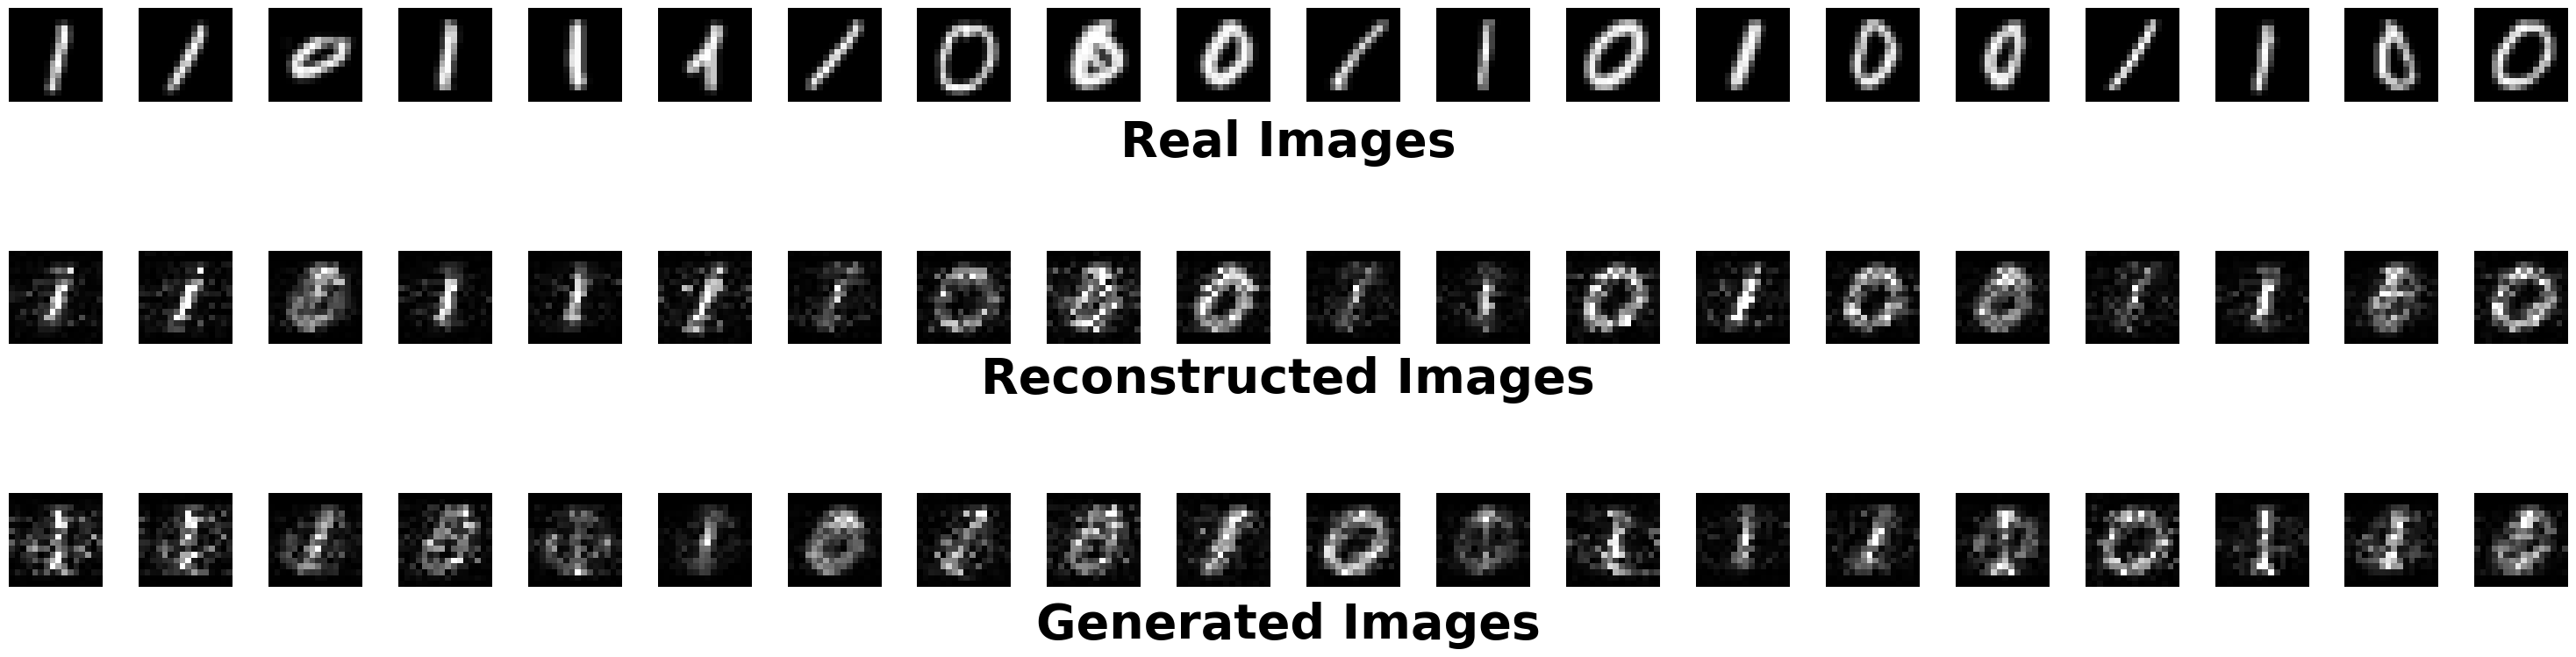

In [6]:
####  Check visually the outcome of the training

generator.eval()
encoder.eval()

# Generate random latent vectors for n images
z = 2 * torch.rand(20, latent_dim, device=device) - 1

with torch.no_grad():
    generated_images = generator(z).cpu()
    real_images, _ = next(iter(dataloader))
    real_images = real_images.to(device)[:20]  # Select the first 20 images
    encoded_vecs = encoder(real_images, latent_dim)
    reconstructed_images = generator(encoded_vecs).cpu()

# Denormalization function
def denormalize(images):
    return (images * 0.5) + 0.5

# Denormalize images
generated_images = denormalize(generated_images)
real_images = denormalize(real_images.cpu())
reconstructed_images = denormalize(reconstructed_images)

# Function to prepare images for display
def prepare_image_for_display(image):
    image = image.permute(1, 2, 0)
    return image.numpy()

# Plotting
fig, axs = plt.subplots(3, 20, figsize=(30, 10))  # Adjusted for more vertical space
for i in range(20):
    axs[0, i].imshow(prepare_image_for_display(real_images[i]), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(prepare_image_for_display(reconstructed_images[i]), cmap='gray')
    axs[1, i].axis('off')
    axs[2, i].imshow(prepare_image_for_display(generated_images[i]), cmap='gray')
    axs[2, i].axis('off')

# Adding captions below each row
captions = ['Real Images', 'Reconstructed Images', 'Generated Images']

plt.figtext(0.5, 0.65 , 'Real Images', ha='center', va='bottom', fontsize=40, fontweight='bold')
plt.figtext(0.5, 0.38 , 'Reconstructed Images', ha='center', va='bottom', fontsize=40, fontweight='bold')
plt.figtext(0.5, 0.10 , 'Generated Images', ha='center', va='bottom', fontsize=40, fontweight='bold')

plt.tight_layout(pad=3.0)

# Save the figure as a PNG file
composite_image_path = os.path.join(out_dir, 'composite-{}.png'.format(batches_done))  # Define composite image path
plt.savefig(composite_image_path, dpi=150)  # Save the composite image

plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1980 samples in 0.004s...
[t-SNE] Computed neighbors for 1980 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1980
[t-SNE] Computed conditional probabilities for sample 1980 / 1980
[t-SNE] Mean sigma: 0.334507
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.670006
[t-SNE] KL divergence after 2000 iterations: 0.984712


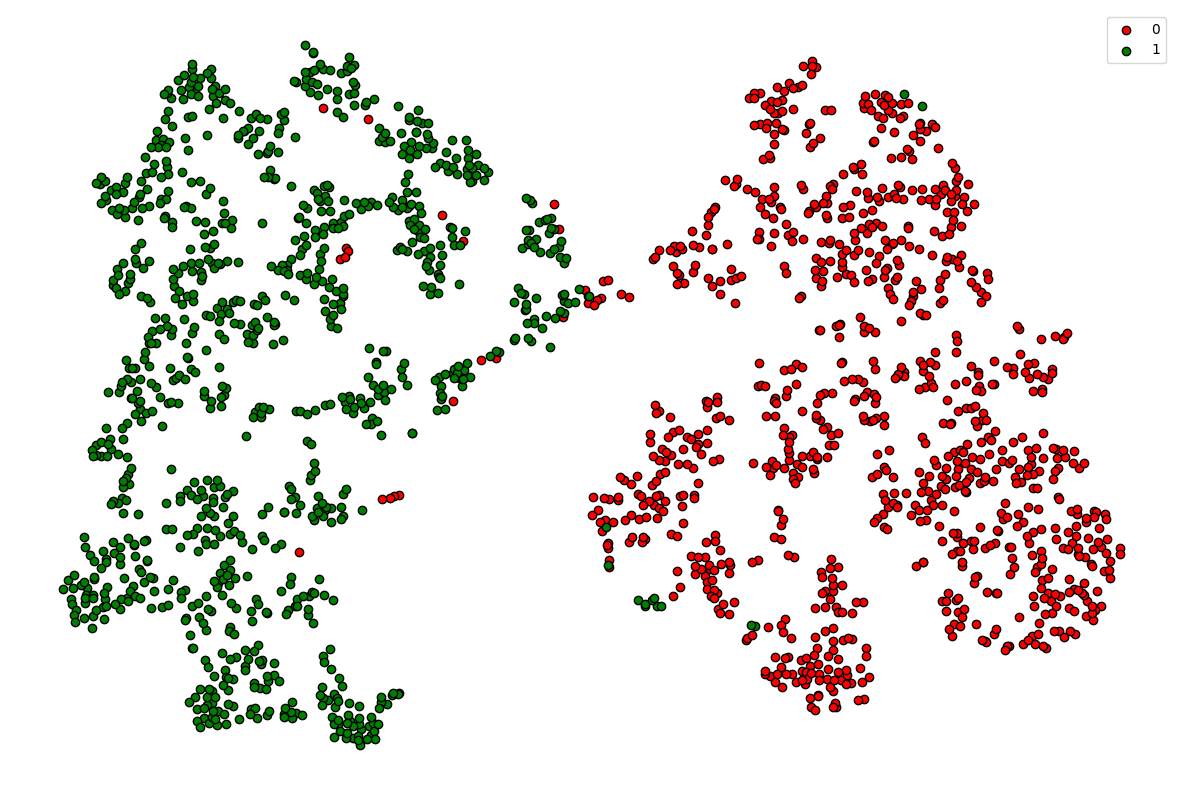

In [7]:
####  T-SNE analisys

encoder.eval()

def extract_features_and_labels(datloa):
    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in datloa:
            images = images.to(device)
            features = encoder(images, latent_dim).cpu().numpy()
            features_list.append(features)
            labels_list.append(labels.numpy())

    # Concatenate all collected items
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return features, labels

# Extract features and labels for training and test datasets
EX_train, y_train = extract_features_and_labels(dataloader)
EX_test, y_test = extract_features_and_labels(dataloader_test)



tsne = TSNE(n_components=2, random_state=42, learning_rate=70, n_iter=2000, n_iter_without_progress=400, verbose=1)
EX2D = tsne.fit_transform(EX_test)

plt.figure(figsize=(15,10))
#colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightblue', 'orange', 'gray']
colors = ['r', 'g']

for i in range(2):  # Assuming classes 0-9 for MNIST
    idx = y_test == i
    plt.scatter(EX2D[idx, 0], EX2D[idx, 1], c=colors[i], label=str(i), edgecolor='k')

plt.legend()
plt.axis('off')
plt.show()

In [8]:
# Reuse EX_train, y_train, EX_test, y_test

# Initialize UMAP;  n_neighbors and min_dist parameters 

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', random_state=42)

# Fit the model to your data and transform it to a 2D space
UMAP_2D = reducer.fit_transform(EX_test)

plt.figure(figsize=(15,10))
colors = ['r', 'g']  # Adjust colors if you have more labels

for i in range(2):  # Assuming binary classes as in your t-SNE example
    idx = y_test == i
    plt.scatter(UMAP_2D[idx, 0], UMAP_2D[idx, 1], c=colors[i], label=str(i), edgecolor='k')

plt.legend()
plt.axis('off')
plt.show()

C:\Users\giuse\.conda\envs\QML_Pytorch_Pennylane\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [9]:
####  T-SNE analisys   latent space generator II

#classes_str = "0 1"  
#classes = list(set([int(digit) for digit in classes_str.split()]))
#dataset_test = select_from_dataset(load_mnist_test(image_size=16), 200, classes)
#dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=1)

encoder.eval()

def extract_features_and_labels(datloa):
    features_list = []
    labels_list = []
    features_list_2 = []
    labels_list_2 = []

    with torch.no_grad():
        for images, labels in datloa:
            features = encoder(images,latent_dim)
            recon_img = generator(features)
            features_2 = encoder(recon_img, latent_dim).numpy()
            #features = encoder(images, latent_dim).cpu().numpy()
            features_list.append(features)
            labels_list.append(labels.numpy())
            features_list_2.append(features_2)
            labels_list_2.append(labels.numpy())

    # Concatenate all collected items
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    features_2 = np.concatenate(features_list_2, axis=0)
    labels_2 = np.concatenate(labels_list_2, axis=0)
    #print("features",features)
    #print("features_2",features_2)
    return features, labels, features_2, labels_2

# Extract features and labels for training and test datasets
#EX_train, y_train, EX_train_2, y_train_2 = extract_features_and_labels(dataloader)
EX_test, y_test, EX_test_2, y_test_2 = extract_features_and_labels(dataloader_test)

tsne = TSNE(n_components=2, random_state=42, learning_rate=70, n_iter=2000, n_iter_without_progress=400, verbose=1)
EX2D_2 = tsne.fit_transform(EX_test_2)
#tsne = TSNE(n_components=2, random_state=42, learning_rate=70, n_iter=2000, n_iter_without_progress=400, verbose=1)
EX2D = tsne.fit_transform(EX_test)


plt.figure(figsize=(15,10))
#colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightblue', 'orange', 'gray']
colors = ['r', 'g']
colors_2 = ['b', 'y']

for i in range(2):  # Assuming classes 0-9 for MNIST
    idx = y_test == i
    plt.scatter(EX2D[idx, 0], EX2D[idx, 1], c=colors[i], label=str(i), edgecolor='k')
    idx_2 = y_test_2 == i
    plt.scatter(EX2D_2[idx, 0], EX2D_2[idx, 1], c=colors_2[i], label=str(i), edgecolor='k')

plt.legend()
plt.axis('off')
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1980 samples in 0.000s...
[t-SNE] Computed neighbors for 1980 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1980
[t-SNE] Computed conditional probabilities for sample 1980 / 1980
[t-SNE] Mean sigma: 0.158029
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.356010
[t-SNE] KL divergence after 2000 iterations: 0.826149
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1980 samples in 0.000s...
[t-SNE] Computed neighbors for 1980 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1980
[t-SNE] Computed conditional probabilities for sample 1980 / 1980
[t-SNE] Mean sigma: 0.334507
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.670242
[t-SNE] KL divergence after 2000 iterations: 0.984897


In [10]:
###  use KNeighbors Classifier

from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=1)
KNN.fit(EX_train, y_train)  # Fit on the encoded training set
predictions = KNN.predict(EX_test)  # Predict on the encoded test set
accuracy = np.mean(predictions == y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 99.04%


In [11]:
###  Evalaute performance of the critic 

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

generator.eval()
encoder.eval()
critic.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n = 100  # Number of samples to generate/evaluate

# Generate 'n' random latent vectors
z = 2 * torch.rand(n, latent_dim, device=device) - 1

# Generate 'n' fake images using the generator
fake_images = generator(z)

# Sample 'n' real images from dataset
real_images = torch.stack([dataset[i][0] for i in range(n)]).to(device)

# Evaluate the critic on both real and fake images (considering also the latent vectors)

fake_preds = critic(fake_images, z).view(-1)
real_preds = critic(real_images, encoder(real_images,latent_dim)).view(-1)

# Convert critic predictions to binary labels (0 for fake, 1 for real) and calculate metrics
predictions = torch.cat((torch.sigmoid(real_preds), torch.sigmoid(fake_preds))).round().detach().cpu().numpy()
true_labels = torch.cat((torch.ones(n), torch.zeros(n))).cpu().numpy()  # This line is fine since it's already only dealing with CPU tensors without requires_grad

precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

Precision: 0.5000, Recall: 1.0000, F1 Score: 0.6667


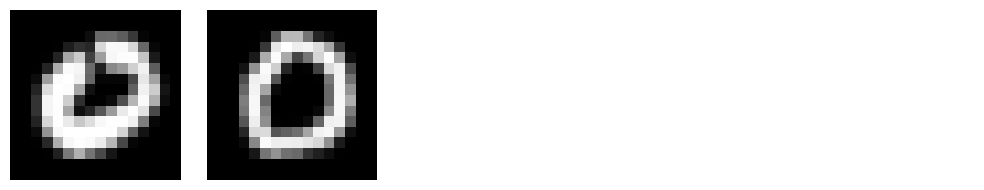

In [12]:
#####   Anomaly Detection

classes_str = "0 1"  
classes = list(set([int(digit) for digit in classes_str.split()]))
dataset_test = select_from_dataset(load_mnist_test(image_size=16), 20, classes)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=1)

# Considering that images in dataloader have pixels with values in range [-1, 1] they are here to inetrval [0,1]
# with function denorm before calculating the MSE and showing the results

def calculate_reconstruction_error(data, encoder, generator, latent_dim, device):
    data = data.to(device)
    data = denorm(data)
    
    with torch.no_grad():
        encoded_data = encoder(data, latent_dim)
        reconstructed_data = generator(encoded_data)
        reconstructed_data = denorm(reconstructed_data)
    return torch.mean(torch.pow(data - reconstructed_data, 2), dim=(1, 2, 3))  # Mean squared error per sample

def detect_anomalies(dataloader_test, encoder, generator, latent_dim, device, threshold):
    encoder.eval()
    generator.eval()
    anomalies = []
    for imgs, _ in dataloader_test:
        reconstruction_error = calculate_reconstruction_error(imgs, encoder, generator,latent_dim, device)
        anomalies.extend(denorm(imgs[reconstruction_error > threshold]).cpu().numpy())  # Collect anomalies
    return anomalies

# Example usage
threshold = 0.13  # Set based on validation set or expert judgment
anomalies = detect_anomalies(dataloader_test, encoder, generator, latent_dim, device, threshold)


import matplotlib.pyplot as plt
import numpy as np

def show_anomalies(anomalies, num_images=20):
    
##    Display a grid of anomaly images.
    
    if not anomalies:
        print("No anomalies detected.")
        return
    
    # Determine how many images to display
    num_images = min(num_images, len(anomalies))
    
    # Randomly select images to display if there are more anomalies than num_images
    selected_indices = np.random.choice(len(anomalies), num_images, replace=False)
    selected_anomalies = np.array(anomalies)[selected_indices]
    
    # Calculate grid size
    num_cols = 5
    num_rows = num_images // num_cols + (0 if num_images % num_cols == 0 else 1)
    
    # Create figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 2))
    axes = axes.flatten()
    
    for i, img in enumerate(selected_anomalies):
        ax = axes[i]
        ax.imshow(img.squeeze(), cmap='gray', interpolation='none')
        ax.axis('off')
    
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display detected anomalies
show_anomalies(anomalies)